In [1]:
!nvidia-smi

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Thu Sep 14 10:08:03 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 536.99       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti     On  | 00000000:01:00.0 Off |                  N/A |
|  0%   36C    P8              10W / 220W |    543MiB /  8192MiB |     10%      Default |
|                                         |                      |                  

In [2]:
import tensorflow as tf

print(tf.__version__)


tf.config.list_physical_devices('GPU') 

2.9.1


2023-09-14 10:08:22.831155: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-14 10:08:22.854809: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-09-14 10:08:22.854828: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[]

In [7]:
pwd

'/home/ralphpark/aiffel'

# 3. 뉴스 요약봇 만들기

## 3-1. 들어가며

### 학습 내용
2. 텍스트 요약(Text Summarization)
 - 텍스트 요약 방법인 추출적 요약(Extractive Summarization)과 추상적 요약(Abstractive Summarization)에 대해서 알아봅니다.
3. 인공 신경망으로 텍스트 요약 훈련시키기
 - seq2seq 모델에 대한 개요와 구조 그리고 요소들에 대해서 알아봅니다.
4. 데이터 준비하기
 - Kaggle에서 제공하는 아마존 리뷰 데이터셋을 다운받고, 데이터를 확인해 봅니다.
5.  ~ 7. 데이터 전처리하기
 - 불용어 제거, 정규화, 정수인코딩 등의 데이터 전처리 과정을 코드로 구현합니다.
8. 모델 설계하기
 - 인코더와 디코더, 어텐셔을 설계하고 코드로 구현합니다.
9. 모델 훈련하기
 - EarlyStopping에 대해서 알아보고, 이를 적용하여 모델을 학습합니다.
10. 인퍼런스 모델 구현하기
 - 정수 인덱스 행렬로 나온 결과값을 실제 데이터로 복원하는 인퍼런스 모델을 코드로 구현합니다.
11. 모델 테스트하기
 - 모델을 통해 얻은 요약문과 실제 요약문을 비교해 봅니다.
12. 추출적 요약 해보기
 - summa 패키지를 사용하여 추출적 요약(Extractive Summarization)을 해봅니다.

### 학습 목표

Extractive/Abstractive summarization 이해할 수 있습니다.

단어장 크기를 줄이는 다양한 text normalization 적용할 수 있습니다.

seq2seq의 성능을 Up시키는 Attention Mechanism 적용할 수 있습니다.

## 3-2. 텍스트 요약(Text Summarization)이란?

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/E-21-1.png)
텍스트 요약(Text Summarization)이란 위 그림과 같이 긴 길이의 문서(Document) 원문을 핵심 주제만으로 구성된 짧은 요약(Summary) 문장들로 변환하는 것을 말합니다. 예를 들어 상대적으로 큰 텍스트인 뉴스 기사로 작은 텍스트인 뉴스 제목을 만들어내는 것이 텍스트 요약의 대표적인 예라고 할 수 있어요.

이때 중요한 것은 요약 전후에 정보 손실 발생이 최소화되어야 한다는 점입니다. 이것은 정보를 압축하는 과정과 같습니다. 비록 텍스트의 길이가 크게 줄어들었지만, 요약문은 문서 원문이 담고 있는 정보를 최대한 보존하고 있어야 합니다. 이것은 원문의 길이가 길수록 만만치 않은 어려운 작업이 됩니다. 사람이 이 작업을 수행한다 하더라도 긴 문장을 정확하게 읽고 이해한 후, 그 의미를 손상하지 않는 짧은 다른 표현으로 원문을 번역해 내야 하는 것입니다.

그렇게 요약 문장을 만들어 내려면 어떤 방법을 사용하면 좋을까요? 여기서 텍스트 요약은 크게 추출적 요약(Extractive Summarization)과 추상적 요약(Abstractive Summarization)의 두 가지 접근으로 나누어볼 수 있습니다.

### 추출적 요약(Extractive Summarization)
첫 번째 방식인 추출적 요약은 단어 그대로 원문에서 문장들을 추출해서 요약하는 방식이에요. 가령, 10개의 문장으로 구성된 텍스트가 있다면, 그중 핵심적인 문장 3개를 꺼내와서 3개의 문장으로 구성된 요약문을 만드는 식이죠. 그런데 꺼내온 3개의 문장이 원문에서 중요한 문장일 수는 있어도, 3개의 문장의 연결이 자연스럽지 않을 수는 있거든요. 결과로 나온 문장들 간의 호응이 자연스럽지 않을 수 있다는 것이죠. 딥 러닝보다는 주로 전통적인 머신 러닝 방식에 속하는 텍스트 랭크(TextRank)와 같은 알고리즘을 사용해서 이 방법을 사용한다고 해요.

이런 방식을 이미 서비스에 도입해서 활용하고 있는 사례가 있다는 것, 알고 계셨나요? 가장 대표적인 것이 네이버 뉴스 서비스에 있는 요약봇 기능입니다.

네이버 뉴스에 접속해서 아무 뉴스 기사나 클릭해 봅시다. 제목 우하단의 요약봇 버튼을 다시 클릭해 보세요. 기사 원문을 단 3줄로 요약한 글을 보실 수 있습니다. 어떤가요? 가끔은 세 문장 간 연결이 조금 매끄럽지 않게 느껴질 때도 있지만 꽤 그럴듯한 요약문으로 보입니다. 위에서 소개한 TextRank 알고리즘을 통해 해당 기사를 가장 잘 대표하는 단어들로 이루어진 핵심문장을 아주 효과적으로 찾아내기 때문입니다. 잘 찾아보면 요약문에 사용된 문장 3개가 원문에 그대로 있다는 것을 알 수 있을 것입니다.

### 추상적 요약(Abstractive Summarization)
두 번째 방식인 추상적 요약은 추출적 요약보다 좀 더 흥미로운 접근을 사용합니다. 원문으로부터 내용이 요약된 새로운 문장을 생성해내는 것이죠. 여기서 새로운 문장이라는 것은 결과로 나온 문장이 원문에 원래 없던 문장일 수도 있다는 것을 의미합니다. 자연어 처리 분야 중 자연어 생성(Natural Language Generation, NLG)의 영역인 셈이죠. 반면, 추출적 요약은 원문을 구성하는 문장 중 어느 것이 요약문에 들어갈 핵심문장인지를 판별한다는 점에서 문장 분류(Text Classification) 문제로 볼 수 있을 것입니다.

자연어 생성하면 혹시 떠오르는 신경망이 있나요? 가장 기본적인 신경망 중 하나인데... 맞아요! RNN으로 이 문제를 풀 수 있겠군요! 그렇다면, RNN으로 추상적 요약 방식을 구현한다고 하면 문제가 전혀 없을까요?

Q. RNN은 학습 데이터의 길이가 길어질수록 먼 과거의 정보를 현재에 전달하기 어렵다는 문제가 있습니다. 이 문제를 해결하기 위해 LSTM과 GRU가 등장했고, 이 둘도 부족해서 어텐션(Attention) 메커니즘이 등장했지요. 이 문제의 이름은 무엇인가요?

장기 의존성(long term dependencies) 문제

장기 의존성 문제는 순환 신경망(RNN)에서 발생하는 문제로, 학습 데이터의 길이가 길어질수록 먼 과거의 정보를 현재에 전달하기 어렵다는 것을 의미합니다. RNN은 시간적인 의존성을 모델링하는 데 강점이 있지만, 그래디언트 소실 또는 그래디언트 폭주와 같은 문제로 인해 장기적인 의존성을 적절히 학습하기 어려울 수 있습니다.

장기 의존성 문제를 해결하기 위해 등장한 LSTM(Long Short-Term Memory)과 GRU(Gated Recurrent Unit)은 RNN의 변형 구조로, 기본 RNN보다 더 긴 시간 간격에서의 정보를 보다 효과적으로 전달할 수 있도록 설계되었습니다. LSTM과 GRU는 게이트 메커니즘이라는 구조를 도입하여 그래디언트 흐름을 제어하고 장기적인 의존성을 캡처할 수 있는 기능을 제공합니다.

그러나 LSTM과 GRU도 모든 상황에서 완벽한 해결책은 아니며, 특히 입력 시퀀스가 매우 긴 경우에도 여전히 한계가 있습니다. 이에 따라 어텐션 메커니즘이 등장하였습니다. 어텐션은 입력 시퀀스의 다양한 위치에 주목(attention)하여 중요한 정보를 집중(concentrate)시키고, 필요한 정보에 가중치를 부여하여 모델이 장기 의존성을 보다 효과적으로 학습할 수 있게 돕습니다.

그저 RNN을 이용해 Language Generation을 한다고 해서 긴 문장을 읽고 나서 요약문을 뚝딱 만들어내긴 어렵겠죠. 어떤 방법을 사용할 지 고민을 할 때, 잘 하는 친구들은 어떻게 하는지 찾아보는 것은 꽤 많은 도움이 돼요. ML 분야의 선구자라고 할 수 있는 기업 '구글(Google)'은 자신들의 서비스에 어떤 방식으로 텍스트 요약을 시도했었을까요? 2016년의 아래 기사에 따르면, 구글은 뉴스 기사 내용으로부터 자동으로 뉴스 제목을 뽑아내는 텍스트 요약 모델을 구현했었다고 합니다. 어떻게 구현했는지, 잠깐 읽어볼까요?


구글 인공지능 "뉴스 제목도 잘 뽑네"

https://zdnet.co.kr/view/?no=20160905114833&from=Mobile

Q. 구글에서 텍스트 요약을 위해 시도했던 접근법 중에, 텍스트마이닝 분야의 '역문서빈도(IDF)같은' 지표를 활용해 문서 안에서 중요해 보이는 부분을 추출하고 그걸 요약문에 담는 방식을 썼을 때의 문제점은 무엇이었나요?

원문에서 발췌하는 방식(Extractive summarization)의 요약 기법은 어색하거나 문법적으로 이상한 결과물을 만드는 문제가 있음

Q. 구글은 짧은 문장. 요약문을 생성하는 모델을 딥 러닝을 통해 end-to-end로 설계하도록 했어요. 구글이 메일서비스에 적용한 자동 회신(Smart Reply) 기능을 만든 것과 비슷한 딥러닝 기법이기도 한 인코더와 디코더의 구조로 구성된 이 딥 러닝 아키텍처의 이름은 무엇일까요?

구글이 메일서비스에 적용한 자동 회신(Smart Reply) 기능과 유사한 딥러닝 기법으로 구성된 딥 러닝 아키텍처의 이름은 "Sequence-to-Sequence (Seq2Seq) 모델"입니다. Seq2Seq 모델은 인코더와 디코더라는 두 개의 주요 구성 요소로 이루어져 있습니다.

인코더는 입력 시퀀스(예: 원본 문장)를 고정된 크기의 잠재 벡터(latent vector)로 인코딩하는 역할을 합니다. 이 잠재 벡터는 입력 시퀀스의 의미와 정보를 담고 있습니다.

디코더는 인코더에서 얻은 잠재 벡터를 기반으로 출력 시퀀스(예: 요약문)를 생성하는 역할을 합니다. 디코더는 시작 토큰을 입력으로 받아서 한 번에 하나의 토큰을 생성하며, 이전에 생성된 토큰들과 현재 상태를 사용하여 다음 토큰을 예측합니다. 이런 식으로 디코더가 한 단어(또는 문자) 씩 출력하여 최종적으로 요약문을 완성합니다.

Seq2Seq 모델은 번역, 대화 생성, 요약 등 다양한 자연어 처리 작업에서 활용되며, 구글의 Smart Reply와 같이 짧은 문장에 대한 요약/응답 생성에도 사용됩니다.

## 3-3. 인공 신경망으로 텍스트 요약 훈련시키기

우리는 seq2seq 모델을 통해서 Abstractive summarization 방식의 텍스트 요약기를 만들어볼 거예요. seq2seq은 두 개의 RNN 아키텍처를 사용하여 입력 시퀀스로부터 출력 시퀀스를 생성해 내는 자연어 생성 모델입니다. 주로 뉴럴 기계번역에 사용되는 이 모델이 텍스트 요약에도 사용될 수 있을지 갸우뚱하실 수도 있겠지만, 원문을 요약문으로 번역한다고 생각한다면 전혀 무리가 없겠죠?

seq2seq 개요

![](https://d3s0tskafalll9.cloudfront.net/media/images/E-21-2.max-800x600.png)

https://medium.com/dl-for-product-and-service/abstractive-text-summary-with-reinforcement-learning-ab2458ab29d5

원문을 첫 번째 RNN인 인코더로 입력하면, 인코더는 이를 하나의 고정된 벡터로 변환해요. 이 벡터를 문맥 정보를 가지고 있는 벡터라고 하여 컨텍스트 벡터(context vector)라고 합니다. 두 번째 RNN인 디코더는 이 컨텍스트 벡터를 전달받아 한 단어씩 생성해내서 요약 문장을 완성하는 거죠.

###  LSTM과 컨텍스트 벡터

우리는 seq2seq를 구현할 때, 인코더/디코더로 바닐라 RNN이 아니라 LSTM을 사용할 거예요.

![](https://d3s0tskafalll9.cloudfront.net/media/images/E-21-3.max-800x600.png)

[RNN과 LSTM]
http://colah.github.io/posts/2015-08-Understanding-LSTMs

LSTM이 바닐라 RNN과 다른 점은 다음 time step의 셀에 hidden state뿐만 아니라, cell state도 함께 전달한다는 점이에요. 다시 말해, 인코더가 디코더에 전달하는 컨텍스트 벡터 또한 hidden state h와 cell state c 두 개의 값 모두 존재해야 한다는 뜻이죠.

### 시작 토큰과 종료 토큰

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/E-21-4.png)

[시작 토큰 SOS와 종료 토큰 EOS는 각각 start of a sequence와 end of a sequence를 나타낸다]
https://arxiv.org/pdf/1812.02303.pdf

seq2seq 구조에서 디코더는 시작 토큰 SOS가 입력되면, 각 시점마다 단어를 생성하고 이 과정을 종료 토큰 EOS를 예측하는 순간까지 멈추지 않아요. 다시 말해 훈련 데이터의 예측 대상 시퀀스의 앞, 뒤에는 시작 토큰과 종료 토큰을 넣어주는 전처리를 통해 어디서 멈춰야 하는지 알려줄 필요가 있겠죠.

### 어텐션 메커니즘을 통한 새로운 컨텍스트 벡터 사용하기

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/E-21-5.png)

[기존의 컨텍스트 벡터보다 인코더의 정보를 적극적으로 활용하여 성능을 끌어올리는 어텐션 메커니즘]
https://arxiv.org/pdf/1812.02303.pdf

우리는 기존에 배운 seq2seq를 수정하고, 새로운 모듈을 붙여 모델의 성능을 높여볼 거예요. 기존의 seq2seq는 인코더의 마지막 time step의 hidden state를 컨텍스트 벡터로 사용했어요. 하지만 RNN 계열의 인공 신경망(바닐라 RNN, LSTM, GRU)의 한계로 인해 이 컨텍스트 정보에는 이미 입력 시퀀스의 많은 정보가 손실이 된 상태가 됩니다.

어텐션 메커니즘(Attention Mechanism) 은 이와 달리, 인코더의 모든 step의 hidden state의 정보가 컨텍스트 벡터에 전부 반영되도록 하는 것입니다. 하지만 인코더의 모든 hidden state가 동일한 비중으로 반영되는 것이 아니라, 디코더의 현재 time step의 예측에 인코더의 각 step이 얼마나 영향을 미치는지에 따른 가중합으로 계산되는 방식입니다.

위 그림의 예로 들자면, seq2seq 모델이라면 디코더로 전달되는 인코더의 컨텍스트 벡터는 인코더의 마지막 스텝의 hidden state인 $h_5$ 가 되겠지만, 어텐션 메커니즘이 적용된 seq2seq인 Attentional seq2seq이라면 인코더의 컨텍스트 벡터는 예를 들어 $0.2h_1 + 0.3h_2 + 0.1h_3 + 0.15h_4 + 0.25h_5$ 가 될 수도 있는 것입니다.

여기서 주의해야 할 것은, 컨텍스트 벡터를 구성하기 위한 인코더 hidden state의 가중치 값은 디코더의 현재 스텝이 어디냐에 따라 계속 달라진다는 점입니다. 즉, 디코더의 현재 문장 생성 부위가 주어부인지 술어부인지 목적어인지 등에 따라 인코더가 입력 데이터를 해석한 컨텍스트 벡터가 다른 값이 된다는 것입니다. 이와 달리, 기본적인 seq2seq 모델에서 컨텍스트 벡터는 디코더의 현재 스텝 위치에 무관하게 한번 계산되면 고정값을 가집니다.

이렇게 디코더의 현재 스텝에 따라 동적으로 달라지는 인코더의 컨텍스트 벡터를 사용해서 현재의 예측에 활용하면, 디코더가 좀 더 정확한 예측을 할 수 있게 돼요. 이러한 Attention 기법은 seq2seq을 비롯하여 향후 다양한 딥러닝 분야를 획기적으로 발전시킨 핵심 개념이 됩니다. 특히 자연어처리 분야에서는 두말할 것도 없겠죠? 아직은 Attention 개념이 명확하게 와닿지 않을지라도, 앞으로도 수차례에 걸쳐 이 개념에 대해 더욱 깊이 있게 다루게 될 것입니다.

Q. SOS 토큰과 EOS 토큰을 사용하는 이유가 무엇인가요?

SOS 토큰은 디코더에 입력되는 첫 번째 토큰으로 사용되며, 디코더가 문장 생성을 시작하도록 합니다. EOS 토큰은 디코더가 문장 생성을 끝내야 할 때 사용되며, 디코더가 문장 생성을 멈추게 합니다. 즉, SOS 토큰과 EOS 토큰은 seq2seq 모델이 문장 생성을 시작하고 끝내는 시점을 알려주는 역할을 하기 위함 입니다.

Q. Attention 모델과 seq2seq 모델의 차이점이 무엇인가요?

Attention 모델에서는 모든 스텝의 hidden state의 정보가 컨텍스트 벡터에 반영됩니다. 그리고 디코더가 출력을 생성할 때, 컨텍스트 벡터에 반영된 각각의 hidden state에 대한 가중치 값은 디코더의 현재 스텝이 어딘지에 따라 다르게 반영됩니다.

지금까지의 내용을 정리해볼게요.

seq2seq를 사용합니다.
RNN 계열 중 LSTM을 사용하므로 hidden state뿐만 아니라 cell state도 사용해야 합니다.
디코더의 예측 시퀀스에는 시작 토큰 SOS와 예측 토큰 EOS를 시퀀스의 앞, 뒤로 붙입니다.
seq2seq를 구동시키면 디코더는 시작 토큰을 입력받아 예측을 시작합니다.
seq2seq 기본 모델과 달리, 어텐션 메커니즘을 이용해 인코더의 hidden state의 중요도를 취합한 컨텍스트 벡터를 디코더 스텝별로 계산합니다.
계산된 컨텍스트 벡터를 이용해서 디코더는 다음 등장할 단어를 예측합니다.

## 3-4. 데이터 준비하기


$ mkdir -p ~/aiffel/news_summarization/data


오늘 우리가 텍스트 요약 모델 학습에 사용할 데이터셋은 Kaggle에서 제공된 아마존 리뷰 데이터셋입니다.

https://d3s0tskafalll9.cloudfront.net/media/documents/Reviews.csv.zip

$ ln -s ~/data/*.csv ~/aiffel/news_summarization/data

이번 실습에서는 NLTK의 불용어(stopwords)를 사용할 거에요. NTLK와 NLTK 데이터셋이 설치되어 있지 않은 환경이라면 우선 NLTK를 설치하고 NTLK의 데이터셋을 다운로드해 주세요.

NLTK는 Natural Language Toolkit의 축약어로 영어 기호, 통계, 자연어 처리를 위한 라이브러리에요. 이 NLTK에는 I, my, me, over, 조사, 접미사와 같이 문장에는 자주 등장하지만, 의미를 분석하고 요약하는 데는 거의 의미가 없는 100여개의 불용어가 미리 정리되어 있어요. 이를 이용해 다운로드한 리뷰 파일에서 불용어를 제거하는 작업을 진행할 예정이에요.

NLTK 패키지에서 불용어 사전을 다운로드하고, 데이터 전처리를 위한 나머지 패키지도 함께 불러와 볼까요.

In [3]:
!pip install nltk

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/home/ralphpark/.bashrc: line 1: syntax error near unexpected token `('
/home/ralphpark/.bashrc: line 1: `i# ~/.bashrc: executed by bash(1) for non-login shells.'
Defaulting to user installation because normal site-packages is not writeable


In [5]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')


=3


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ralphpark/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


링크에서 다운로드 받은 데이터(Reviews.csv)는 총 568,454개의 샘플을 갖고 있어요. 시간상 여기서는 모든 샘플을 사용하지는 않고, 간단히 10만 개의 샘플만 사용해볼게요.

In [6]:
pwd

'/home/ralphpark/aiffel'

data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

In [7]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 100000


출력된 샘플 수를 보면 총 10만 개의 샘플이 잘 불러와진 것을 확인할 수 있습니다. 이 중에 5개만 출력해볼까요?

In [8]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


열이 너무 많아서 보기에 조금 까다롭죠. 사실 전체 데이터 중 Summary 열과 Text 열만 훈련에 사용할 거라, 이 두 개의 열만 별도로 저장하고, 다시 출력해볼게요.

Q. 데이터프레임 data의 Text와 Summary 컬럼의 데이터만 남기는 코드를 작성하세요.

In [9]:
# 데이터프레임 data의 Text와 Summary 컬럼의 데이터만 남기는 코드
data = data[['Text','Summary']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,Text,Summary
44427,This is great to keep your puppy or older dog ...,My dog love this !!!
98314,At 80 cents a piece these are a good deal. The...,tasty
52564,I don't know how I could say whether or not th...,My Kitty Seems To Love It
85509,Absolutely horrible beef jerkey. It is really ...,"Worst beef jerkey I've ever ""tried"" to eat"
25336,It was time to order cat food again and I thou...,The Cats Gave This Two Thumbs Down
57874,This 5 lb bag is the best deal for the Haribo ...,Best Deal for Haribo Gummies
89148,I am very pleased with this product. Deliciou...,Good stuff
53535,Actually love this product 2 packets a day and...,Fluid Intake
20484,"Our cats usually get the ""green can"" Fancy Fea...",More watery than expected; cats are not digest...
76689,I love this coffee.Ive tried them all and I ca...,It makes me want to fix stuff!!!


## 3-5. 데이터 전처리하기 (1) 데이터 정리하기

이제 데이터를 불러왔으니 전처리를 진행해 볼게요. 빈칸으로 존재하는 null 데이터, 의미는 같지만 다른 식으로 작성된 글 같은 중복 항목과 같은 학습할 때 방해가 되는 데이터를 먼저 솎아낼 거예요.

### 중복 샘플과 NULL 값이 존재하는 샘플 제거

우선 데이터의 중복 샘플 유무를 확인해 볼게요.

In [10]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


중복을 제외한다면 Text에는 88,426개, Summary에는 72,348개의 유니크한 데이터가 존재해요. 사실 이 데이터의 Summary는 'Smelly'나 'Good Product'와 같이 아주 간단한 요약들도 많아서 Text가 달라도 Summary는 동일할 수 있어요. 하지만 Text 자체가 중복이 된 경우는 중복 샘플이므로 제거해야겠죠.

데이터프레임의 drop_duplicates()를 사용하면, 손쉽게 중복 샘플을 제거할 수 있어요.

In [11]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


중복이 제거되면서 샘플 수가 88,426개로 줄어들었어요. 그런데 만약 데이터 Null 값을 가지는 샘플이 있었다면, drop_duplicates()가 중복된 Null들을 지워주기는 하겠지만, 여전히 Null 값 한 개가 어딘가 남아있을 수 있어요. 데이터에 Null 값이 남아있는지 볼게요.

데이터프레임에 Null 값이 있는지 확인하는 방법은 .isnull().sum()을 사용하면 알아볼 수 있어요.

In [12]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


Summary에 1개의 Null 값이 있네요. 데이터프레임에서 Null을 제거할 때는 dropna() 함수를 사용하면 돼요.

In [13]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88425


전체 샘플 수가 1개 줄어들어 88,425개의 샘플이 남았네요. 지금까지 중복 샘플과 Null 값이 있는 샘플들을 제거해보았는데 10만 개의 샘플 중 1만 개 이상의 샘플이 제거되었어요.

### 텍스트 정규화와 불용어 제거

살아남은 88,425개의 샘플에는 수많은 단어들이 있어요. 그런데 사실 그 단어들 중에서는 같은 의미인데도 다른 표현으로 쓰여 마치 다른 단어들처럼 간주되는 경우가 있어요.

예를 들어서 it'll은 it will과 같고, mustn't과 must not은 사실 같은 표현이죠. 이런 경우 기계가 굳이 이들을 마치 다른 단어로 간주하게 해서 연산량을 늘리는 것보다는 기계 학습 전에 미리 같은 표현으로 통일시켜주는 것이 기계의 연산량을 줄일 수 있는 방법이에요.

이러한 방법론을 텍스트 처리에서는 텍스트 정규화(text normalization) 라고 해요.

여기서는 텍스트 정규화를 위한 사전(dictionary)을 아래와 같이 구성할 거예요. 이 사전은 아래의 링크에서 참고하여 만들었어요.

정규화 사전 출처
https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [14]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


이제 정규화 준비까지 마쳤어요.

하지만 아직 끝난 게 아니에요. 일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들이 존재해요. 이를 불용어(stopwords)라고 불러요. 때로는 불용어를 제거하는 것이 자연어 처리의 성능을 높이는 방법일 수 있어요. 여기서는 NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거할 거예요.

In [15]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

NLTK에서 미리 정의하여 제공하고 있는 불용어는 총 179개라는 것을 볼 수 있죠. 이를 사용하여 불용어를 제거할 거예요. 이 작업 외에도 모든 영어 문자는 소문자로 만들고, 섞여있는 html 태그를 제거하고, 정규 표현식을 통해 각종 특수문자를 제거해서 정말 필요한 내용만 잘 학습할 수 있도록 처리할 거예요.

함수의 하단을 보면, NLTK를 이용해 불용어를 제거하는 파트가 있는데, 이는 Text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 짧은 Summary 전처리할 때는 호출하지 않을 예정이에요. Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 Summary에는 남아 있는 게 더 좋을 것 같습니다. 이 처리를 위해서 함수의 인자로 remove_stopwords를 추가하고, if문을 추가했어요.

In [16]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


전처리 전, 후의 결과를 확인하기 위해서 임의의 text와 summary를 만들어 함수를 호출해 볼까요.

In [17]:

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


결과를 보면 기본적으로 모든 알파벳이 소문자로 변환되고, <br />과 같은 html 태그가 제거되었죠. (or finish)와 같은 괄호로 묶였던 단어 시퀀스가 제거된 것도 확인할 수 있어요. 또한 특수문자가 제거되면서 영어만 남았어요.

이제 함수가 잘 작동하는 것을 확인했으니, 훈련 데이터 전체에 대해서 전처리를 수행해볼게요. 이때, Text의 경우에는 불용어를 제거하고, Summary의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행해야 해요. 먼저 Text를 전처리하고, 결과를 확인하기 위해서 상위 5개의 줄을 출력해볼게요.

Q. 위의 내용을 참고해서 훈련 데이터 전체의 Text 컬럼의 데이터를 전처리하는 코드를 작성하세요.(반복문 사용)

In [18]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
# 훈련 데이터 전체의 Text 컬럼의 데이터를 전처리하는 코드를 작성
clean_text = []

for s in data['Text']:
    clean_text.append(preprocess_sentence(s))
    

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

/tmp/ipykernel_50325/998782171.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


Text 전처리 후 결과:  ['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']


이제 Summary에 대해서 전처리 함수를 호출해 줄 때는, 불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False를 넣어줄게요.

Q. 위의 내용을 참고해서 훈련 데이터 전체의 Summary 컬럼의 데이터를 전처리하는 코드를 작성하세요.(반복문 사용)

In [19]:
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
clean_summary = []

for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

/tmp/ipykernel_50325/998782171.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
/tmp/ipykernel_50325/998782171.py:4: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


Summary 전처리 후 결과:  ['good quality dog food', 'not as advertised', 'delight says it all', 'cough medicine', 'great taffy']


이렇게 텍스트 정제의 과정을 거친 후에는 다시 한번 빈(empty) 샘플이 생겼는지 확인해보는 것이 좋아요. 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있어요. 이렇게 되면 샘플 자체가 빈 값을 가지게 되겠죠.

보다 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장할게요. 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체해요.

In [20]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


이전과 같이 .isnull().sum()을 사용해서 Null 값이 생겼는지 해볼게요.

In [21]:
data.isnull().sum()

Text        0
Summary    70
dtype: int64

Summary 열에서 70개의 Null 값이 생겼네요. 원래는 단어가 있었는데, 정제 과정에서 모든 단어가 제거되어 빈 샘플이 70개나 생겼다는 의미예요. 이 샘플들은 모두 제거해줄게요.

In [22]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88355


## 3-6. 데이터 전처리하기 (2) 훈련데이터와 테스트데이터 나누기

학습을 진행하기 위해서는 학습에 사용할 데이터의 크기를 결정하고, 문장의 시작과 끝을 표시해 줘야 해요.

### 샘플의 최대 길이 정하기

필요 없는 단어를 모두 솎아낸 데이터를 가지게 되었으니, 이제 훈련에 사용할 샘플의 최대 길이를 정해줄 차례에요.

Text와 Summary의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해서 볼게요.

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


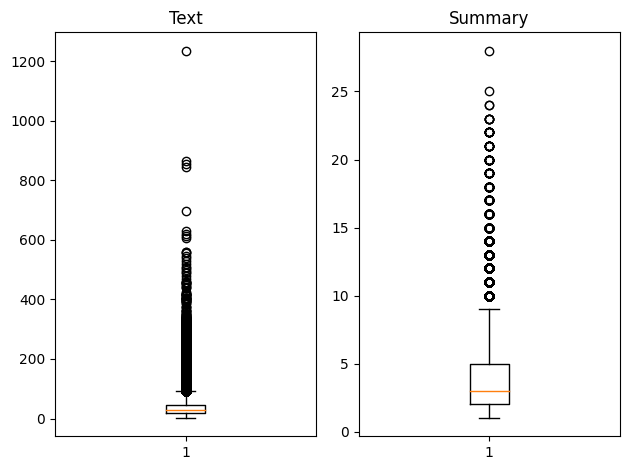

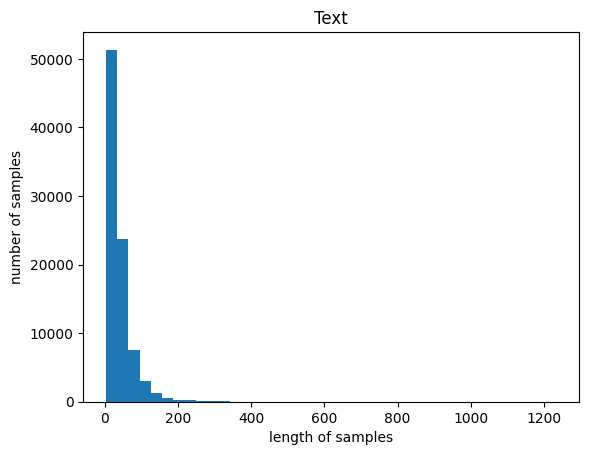

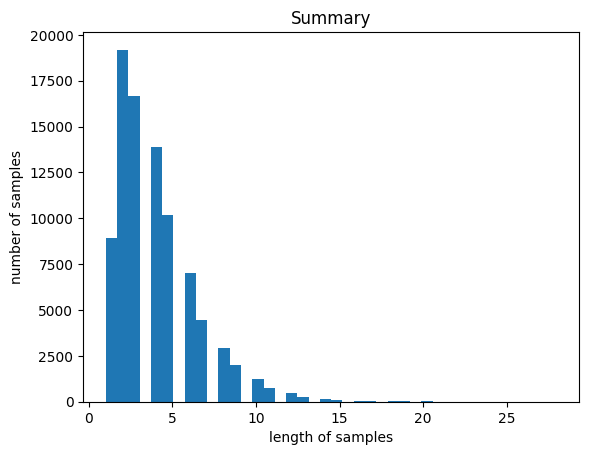

In [23]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위의 그래프처럼, 많은 양의 데이터를 다룰 때는 데이터를 시각화하여 보는 것이 도움이 돼요. 위에서부터 차례대로 그래프는 각각 실제 텍스트와 요약의 길이 분포, 실제 텍스트 샘플 길이별 개수, 요약본 샘플 길이별 개수를 나타내고 있어요.

Text의 경우 최소 길이가 2, 최대 길이가 1,235로 그 차이가 굉장히 크죠. 하지만 평균 길이는 38로 시각화된 그래프로 봤을 때는 대체적으로는 100 내외의 길이를 가진다는 것을 확인할 수 있어요.

Summary의 경우 최소 길이가 1, 최대 길이가 28, 그리고 평균 길이가 4로 Text에 비해 상대적으로 길이가 매우 짧아요. 그래프로 봤을 때에도 대체적으로 10이하의 길이를 가지고 있네요.

이로부터 Text의 최대 길이와 Summary의 적절한 최대 길이를 임의로 정해볼게요.

In [24]:
text_max_len = 50
summary_max_len = 8
print('=3')

=3


각각 50과 8로 정했는데 이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하는 편이 객관적으로 길이를 결정하는 데 도움이 될거예요. 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해볼게요.

In [25]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


이렇게 만든 함수를 Text와 Summary에 적용해 우리가 결정한 임의의 길이가 몇%의 샘플까지 포함하는지 볼 수 있겠죠.

In [26]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


각각 50과 8로 패딩을 하게 되면 해당 길이보다 긴 샘플들은 내용이 잘리게 되는데, Text 열의 경우에는 약 23%의 샘플들이 내용이 망가지게 된다고 하네요.

우리는 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제할게요.

Q. Text와 Summary를 담고 있는 data 데이터프레임을 위에서 임의로 정의한 text_max_len과 summary_max_len의 길이보다 큰 샘플을 제외하는 코드를 작성하세요.
(힌트 : apply 함수와 lamda식을 사용)

In [27]:
#Text와 Summary를 담고 있는 data 데이터프레임을 위에서 임의로 정의한 text_max_len과 summary_max_len의 길이보다 큰 샘플을 제외하는 코드를 작성하세요.(힌트 : apply 함수와 lamda식을 사용)
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]


print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65818


### 시작 토큰과 종료 토큰 추가하기

앞서 시작 토큰과 종료 토큰에 대해서 언급했던 것을 기억하시나요? 디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈추는 거였죠.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/E-21-4.png)

[시작 토큰 SOS와 종료 토큰 EOS는 각각 start of a sequence와 end of a sequence를 나타낸다]
https://arxiv.org/pdf/1812.02303.pdf

seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있어요. 이번 실습에서는 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가할 거예요. 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 이름을 정했어요. 두 개의 문장 모두 Summary 열로부터 만들 거예요.

In [28]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


앞뒤로 토큰이 잘 붙었죠? 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장해 줄게요.

In [29]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


제 훈련 데이터와 테스트 데이터를 분리할거에요.

훈련 데이터와 테스트 데이터를 분리하는 방법은 분리 패키지를 사용하는 방법, 또는 직접 코딩을 통해서 분리하는 방법 등 여러 가지 방법이 있을 텐데 여기서는 직접 해볼게요. 우선, encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어줄게요.

In [30]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[19566 11610 30584 ...  8137 34787 31347]


이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 되겠죠.

In [31]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


이제 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해 줄게요. 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의해 줄게요.

In [32]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13163


이렇게 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분할게요. :표시의 위치에 주의해 주세요.

In [33]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


훈련 데이터와 테스트 데이터가 각각 52,655개와 13,163개로 잘 분리된 것을 볼 수 있어요!

## 3-7. 데이터 전처리하기 (3) 정수 인코딩


### 단어 집합(vocabulary) 만들기 및 정수 인코딩

이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 해요. 이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요해요. 이 과정을 단어 집합(vocabulary) 을 만든다고 표현해요. 훈련 데이터에 대해서 단어 집합을 만들어볼게요. 우선, 원문에 해당되는 encoder_input_train에 대해서 단어 집합을 만들게요.

Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있어요.

In [34]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요. 현재 생성된 단어 집합은 src_tokenizer.word_index에 저장되어 있어요. 그런데 우리는 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행하려고 해요.

등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요.

src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있어요.

In [35]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31860
등장 빈도가 6번 이하인 희귀 단어의 수: 23605
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8255
단어 집합에서 희귀 단어의 비율: 74.08976773383553
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.374280692613025


encoder_input_train에는 3만여 개의 단어가 있네요. 그 아래의 통계 정보들을 해석해볼까요?

등장 빈도가 threshold 값인 7회 미만, 즉 6회 이하인 단어들은 단어 집합에서 무려 70% 이상을 차지하네요. 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.39%밖에 되지 않아요.

그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 합니다. 위에서 이를 제외한 단어 집합의 크기를 8천여 개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 8,000으로 제한해볼게요. 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있어요.

In [36]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [37]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행해요. 현재 단어 집합의 크기를 8,000으로 제한했으니까 이제 8,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않아요.

In [38]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[58, 1136, 3976, 4757, 1048, 1804, 492, 1689, 4493, 234, 357, 58, 4494, 6, 910, 1021, 1689, 6444, 6155, 6156, 49, 13, 56, 1292, 118, 443, 974, 1008, 1185, 7, 192, 475, 220, 560, 1689, 6794, 351], [824, 258, 2333, 9, 1, 62, 3733, 12, 30, 174, 1, 2918, 84, 258, 113, 166, 145, 3600, 1877, 464, 422, 145, 166, 1355, 4079, 1376, 145, 420, 623, 263], [237, 370, 25, 649, 226, 47, 863, 359, 3, 3601, 466, 152]]


이제 더 이상 텍스트 데이터가 아니라 정수가 나오고 있어요.

Summary 데이터에 대해서도 동일한 작업을 수행할게요. 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산해요.

In [39]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요. 이는 tar_tokenizer.word_index에 저장되어 있어요. tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻어서, 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요.

In [40]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10443
등장 빈도가 5번 이하인 희귀 단어의 수: 8048
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2395
단어 집합에서 희귀 단어의 비율: 77.0659772096141
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.845637294993758


등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 77%를 차지하고 있네요. 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 5.87%밖에 되지 않아요. 아까 했던 것과 동일하게 이 단어들은 모두 제거할게요. 어림잡아 2,000을 단어 집합의 크기로 제한할게요.

In [41]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1955, 290, 245], [1, 10, 5, 13, 59, 1557, 131], [1, 29, 9, 185, 264], [1, 59, 626, 395, 10, 5, 139, 9, 174], [1, 137, 149, 104, 51, 62, 15]]
target
decoder  [[1955, 290, 245, 2], [10, 5, 13, 59, 1557, 131, 2], [29, 9, 185, 264, 2], [59, 626, 395, 10, 5, 139, 9, 174, 2], [137, 149, 104, 51, 62, 15, 2]]


정상적으로 정수 인코딩 작업이 끝났어요. 현재 decoder_input_train과 decoder_target_train에는 더 이상 숫자 2,000이 넘는 숫자들은 존재하지 않아요. 그런데 다음 작업인 패딩 하기로 넘어가기 전에 한 가지 점검해야 할 것이 있어요.

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있어요. 이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 4밖에 되지 않았던 요약문(Summary)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높겠죠.

요약문에서 길이가 0이 된 샘플들의 인덱스를 받아와볼게요. 여기서 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않아요. 그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나올 거예요. 길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있을 테니까요.

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해볼게요. 이 샘플들은 모두 삭제할 거예요.

In [42]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1248
삭제할 테스트 데이터의 개수 : 356
훈련 데이터의 개수 : 51407
훈련 레이블의 개수 : 51407
테스트 데이터의 개수 : 12807
테스트 레이블의 개수 : 12807


훈련 데이터와 테스트 데이터 모두 일정량의 샘플들이 제거된 것을 확인할 수 있어요. 이제 거의 다 왔어요.

### 패딩하기

텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 해야 해요. 아까 정해두었던 최대 길이로 패딩 해 줄 거에요. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰줄게요.

In [43]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3


이제 학습에 필요한 데이터 전처리가 모두 끝났어요.

## 3-8. 모델 설계하기

이제는 모델을 설계할 시간이에요. 우선 함수형 API를 이용해서 인코더를 설계해 볼게요.

Q.인코더 LSTM 1을 참고해서 나머지 인코더의 LSTM 2, LSTM 3의 코드를 완성하세요.

In [45]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True ,dropout = 0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

임베딩 벡터의 차원은 128로 정의하고, hidden state의 크기를 256으로 정의했어요. hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터에요. 이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수라고 이해하면 돼요. 다른 신경망과 마찬가지로, 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아니에요.

인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였어요. hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있죠. 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내줘야겠죠?

또한 LSTM은 dropout 뿐 아니라 recurrent dropout까지 사용할 수 있어요. 일반적인 dropout은 레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결해주는 방법이에요.

반면 recurrent dropout은 dropout을 레이어가 아닌 time step마다 해주는 방식이에요. 즉 time step의 입력을 랜덤으로 생략해 주는 거죠. recurrent dropout은 일반적인 dropout와 같이 regularization을 해주는 효과가 있고, 과적합을 방지할 수 있다고 해요.

아래 그림은 일반적인 dropout과, dropout과 recurrent dropout을 동시에 사용한 것을 시각적으로 표현한 것입니다. 색이 있는 화살표는 dropout을 나타낸 것이에요. (색이 다른 것은 다른 dropout mask를 사용했다는 표시인데, 지금은 그냥 넘어가셔도 됩니다.) 코드를 수정해서 LSTM에 dropout과 recurrent dropout을 모두 사용할 수 있습니다. 그렇게 되면 오른쪽 그림과 같은 형태가 되겠군요. 참고로 dropout과 recurrent dropout을 모두 사용한 것을 Variational Dropout이라고도 해요.

![](https://d3s0tskafalll9.cloudfront.net/media/images/seukeurinsyas_2021-10-28_17-19-50.max-800x600.png)

[dropout(왼쪽)과 dropout + recurrent dropout(오른쪽)]
https://arxiv.org/pdf/1512.05287.pdf

참고로 recurrent dropout을 사용하면 아래와 같은 경고문이 뜹니다.

WARNING:tensorflow:Layer lstm_15 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU

recurrent dropout을 사용할 시 cuDNN을 사용할 수 없어서 recurrent dropout을 사용하지 않을 때보다 학습 시간이 오래 걸립니다.

recurrent dropout에 대한 자세한 내용은 아래의 논문을 참고하세요.

Recurrent Dropout without Memory Loss
https://arxiv.org/pdf/1603.05118v2.pdf

이제 디코더를 설계해볼게요!

In [46]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일해요. 하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 해요.

디코더의 출력층을 설계해볼게요.

In [47]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 50, 128)              1024000   ['input_2[0][0]']             
                                                                                                  
 lstm_3 (LSTM)               [(None, 50, 256),            394240    ['embedding_1[0][0]']         
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                              

디코더의 출력층에서는 Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 해요. 그렇기 때문에 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용하고 있어요.

지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq에요. 그런데 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이 있어요! 바로 어텐션 메커니즘이에요.

### 어텐션 메커니즘
어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 뜻이에요. 어텐션 함수를 설계해보는 것은 다음 기회로 미루기로 하고, 여기서는 TensorFlow에 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 배워볼게요. 참고로 여기서 사용하는 어텐션 함수는 Bahdanau 스타일의 어텐션입니다. 이 어텐션에 대한 자세한 설명은 텐서플로우 홈페이지를 참고하세요.

아래와 같이 어텐션 층을 만들고, 위에서 설계한 디코더의 출력층을 수정해 봅시다.

In [48]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 50, 128)              1024000   ['input_2[0][0]']             
                                                                                                  
 lstm_3 (LSTM)               [(None, 50, 256),            394240    ['embedding_1[0][0]']         
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                            

## 3-9. 모델 훈련하기

설계한 모델을 가지고 훈련을 진행해볼게요.

In [49]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50


2023-09-14 01:59:56.983304: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2903 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-09-14 01:59:58.226580: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 104857600 exceeds 10% of free system memory.
2023-09-14 01:59:58.269475: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 104857600 exceeds 10% of free system memory.
2023-09-14 01:59:58.305032: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16384000

201/201 [==============================] - ETA: 0s - loss: 2.9035

2023-09-14 02:02:20.381410: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2903 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


201/201 [==============================] - 161s 778ms/step - loss: 2.9035 - val_loss: 2.5469
Epoch 2/50
201/201 [==============================] - 157s 782ms/step - loss: 2.5472 - val_loss: 2.4775
Epoch 3/50
201/201 [==============================] - ETA: 0s - loss: 2.4695

KeyboardInterrupt: 

'조기 종료'를 뜻하는 EarlyStopping은 특정 조건이 충족되면 훈련을 멈추는 역할을 해요.

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

위 코드에서는 val_loss(검증 데이터의 손실)을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정돼 있어요. EarlyStopping이 작동한다면 epochs가 아무리 크게 설정되어 있어도 모델 훈련을 최적점에서 멈출 수 있겠네요.

EarlyStopping에 대한 자세한 내용은 아래 링크를 참고하세요! 자주 쓰이는 도구이니 자세히 알아두면 매우 도움이 될 거예요!!

Early Stopping

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

Q. Early Stopping을 사용할 경우 조심해야 하는 경우가 있는데, 어떤 경우일까요?

LMS 

patience가 0이 아닌 경우에는 훈련이 종료되었을 때 성능이 최고인 상황이 아닐 수 있습니다. 예를들어 patience가 3인 경우, 15 epoch에서 loss가 감소하다가 16 epoch부터 loss가 증가한다면 18 epoch 때 모델을 저장하고 학습을 종료합니다. 그래서 학습 중에 모델을 저장하는 callback 함수를 같이 사용한다.

GPT

Early Stopping은 모델 훈련 중에 일찍 멈추는 기법으로, 검증 데이터의 성능이 개선되지 않거나 악화될 때 훈련을 조기에 종료시키는 것을 의미합니다. 이 기법은 과적합(overfitting)을 방지하고 일반화 성능을 향상시킬 수 있습니다. 그러나 Early Stopping을 사용할 때 주의해야 할 몇 가지 경우가 있습니다:

1. 너무 일찍 멈추는 경우: Early Stopping은 모델이 더 이상 개선되지 않거나 과적합이 시작될 때 훈련을 종료합니다. 그러나 때로는 모델이 아직 최적의 성능에 도달하지 않았음에도 불구하고, 너무 일찍 훈련이 종료될 수 있습니다. 따라서 적절한 patience(인내) 값과 함께 사용하여 충분한 시간 동안 성능 개선 여부를 확인하는 것이 중요합니다.

2. 잘못된 검증 데이터 선택: Early Stopping은 보통 검증 데이터를 사용하여 모델의 성능을 평가하고 결정합니다. 검증 데이터가 대표성이 없거나 불균형한 경우, Early Stopping에서 얻는 결과가 실제 테스트 데이터에서의 성능과 차이가 날 수 있습니다. 따라서 검증 데이터셋은 실제 환경과 유사하게 구성되어야 합니다.

3. 지역 최소값 문제: 모델 학습 과정에서 경사 하강법 등의 최적화 알고리즘이 지역 최소값(local minimum)에 갇힐 수 있습니다. 이런 경우, 약간의 오차 감소로 인해 큰 개선 없음으로 인해 조기 종료되어 정말로 좋은 전역 최소값(global minimum)에 도달하지 못할 수도 있습니다.

4. 학습률 조정 문제: Early Stopping 시점에서 학습률(learning rate)을 적절하게 조정하지 않으면, 최적화 과정에서 많은 에포크(epoch)를 거치면서 정확도가 높아집니다만, 조기 종료 후 다시 에포크를 진행할 때 학습률 설정 문제로 인해 오히려 정확도가 낮아질 수 있습니다.

5. 다른 하이퍼파라미터와 상호작용 문제: Early Stopping 기법은 다른 하이퍼파라미터와 상호작용할 수 있는데, 예를 들어 네트워크 구조 변경 등 다른 변화와 함께 사용됩니다.
   
따라서 Early Stopping을 적용할 때에는 위와 같은 주의사항들을 염두에 두고 설정 및 관리해야 합니다.
실험 및 경험이 필요한 부분입니다.
모델과 데이터셋에 따라 적절한 파라미터 값을 찾아내기 위해서 반복 실험이 필요할 수 있으며,
검증 데이터셋 선택 및 관리 등 실전 상황과 연관된 요소들도 중요합니다.

이제 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화 해봐요.

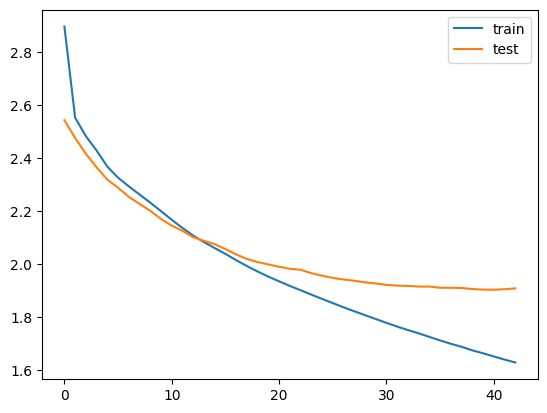

In [49]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 3-10. 인퍼런스 모델 구현하기

테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.

In [50]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다는 것, 알고 계시나요?

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했습니다.

그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

In [51]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


어텐션 메커니즘을 사용하는 출력층을 설계해 주세요.

In [52]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들어주세요.

In [53]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


Q. 정답 문장이 없는 추론(inference) 단계에서는 왜 모델 설계를 별도로 해주어야 하나요?

LMS

생성해야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문입니다.

GPT

정답 문장이 없는 추론(inference) 단계에서 모델 설계를 별도로 해주어야 하는 이유는 다음과 같습니다:

1. 입력 데이터 형식: 훈련 단계와 추론 단계에서 입력 데이터의 형식이 다를 수 있습니다. 예를 들어, 훈련 단계에서는 입력 시퀀스와 해당 시퀀스의 정답 레이블을 함께 사용하여 모델을 학습시키지만, 추론 단계에서는 정답 레이블 없이 입력 시퀀스에 대한 예측을 수행합니다. 따라서 모델 설계를 별도로 해주어야 훈련과 추론 과정 각각에 맞게 데이터 처리 및 모델 구조를 조정할 수 있습니다.

2. Dropout 및 Batch Normalization 등의 적용: 훈련 과정에서 일반적으로 사용되는 Dropout, Batch Normalization 등과 같은 기법들은 모델을 더 강건하게 만들기 위해 사용됩니다. 그러나 이러한 기법들은 훈련 중에만 적용되고, 추론 단계에서는 비활성화되어야 합니다. 따라서 추론 과정에서도 올바른 결과를 얻기 위해 이러한 기법들을 관리하기 위한 별도의 모델 설계가 필요합니다.

3. 파라미터 저장 및 재사용: 일반적으로 훈련된 모델은 파라미터(가중치) 값을 저장하고 나중에 재사용할 수 있습니다. 추론 과정에서 이러한 저장된 파라미터 값을 로드하여 사용할 수 있으며, 이때 별도의 모델 설계가 필요합니다.

4. 하드웨어 및 배포 환경 호환성: 훈련과 추론 단계에서 사용되는 하드웨어 리소스나 배포 환경(예: CPU 또는 GPU)이 다를 수 있습니다. 따라서 각각의 환경에 맞게 최적화된 모델 설계가 필요합니다.

따라서 정답 문장이 없는 추론 단계에서도 올바른 결과를 얻기 위해서는 해당 상황에 맞춰서 별도로 모델을 설계하고 관리해야 합니다.
추론 시점에서 필요한 작업(예측, 분류 등)에 적합하고 최적화된 구조와 동작 방식을 가진 병렬적인 인공지능 아키텍처나 코드 작성 등으로 구현해야 합니다.

## 3-11. 모델 테스트하기


테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하겠죠. 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어볼게요. 함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들 거예요.

Q. seq2text 함수처럼 요약문의 정수 시퀀스를 텍스트로 변환하는 seq2summary 함수 코드를 작성하세요.
(힌트 : 요약문에는 sostoken과 eostoken을 고려해야 함)

In [54]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
# seq2text 함수처럼 요약문의 정수 시퀀스를 텍스트로 변환하는 seq2summary 함수 코드를 작성하세요.
# (힌트 : 요약문에는 sostoken과 eostoken을 고려해야 함)

def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교해보세요.

In [55]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : actual package received shown product picture seriously reduces value beware black friday monday savings company shame amazon kicking holiday season bait switch happy amazon time missed one amazon refunded large enough portion purchase price satisfy kudos response 
실제 요약 : misleading item picture by amazon or the vendor 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  not bad


원문 : purchased sons mos years eat snack dinner knew getting fruit serving tried gave pretty good definitely distinct banana taste fine us like containers think plum organics happy baby comparable products less expensive ella kitchen products would definitely buy though 
실제 요약 : pretty good 
1/1 [==============================] - 0s 27ms/step


2023-09-14 00:32:23.675331: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2903 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1/1 [==============================] - 0s 14ms/step
예측 요약 :  great product


원문 : good know got bad batch tastes bad try risk 
실제 요약 : yuck 
1/1 [==============================] - 0s 14ms/step
예측 요약 :  horrible


원문 : tea tasty love night little soy milk splenda would recommend people trying healthy green tea 
실제 요약 : yummy 
1/1 [==============================] - 0s 14ms/step
예측 요약 :  great tea


원문 : dogs love treats give head approval give best price found always order amazon use training treats since small flavorful fattening dogs 
실제 요약 : my dogs love these treats 
1/1 [==============================] - 0s 14ms/step
예측 요약 :  great treats


원문 : cost san francisco bay cups lowest able find anywhere good coffee deal hard beat 
실제 요약 : good coffee great price 
1/1 [==============================] - 0s 14ms/step
예측 요약 :  great coffee


원문 : person say dog treat yellow lab loves treats like organic product also like newmans charity important recommend treats 
실제 요약 : good dog treat 
1/1

많은 결과가 출력이 되는데, 기존의 요약과는 다른 요약을 출력하면서도 원문의 내용을 담고 있는 의미 있는 요약들이 보이네요. 심지어 일부 요약의 경우에는 원문에 없던 단어를 사용해서 요약을 하기도 하고 있어요. 워드 임베딩과 RNN의 콜라보로 이뤄낸 신기한 성과네요!

물론 슬프게도 그다지 좋지 않은 요약의 예도 꽤나 보이기도 하네요. 성능을 개선하기 위해서는 seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법도 있고, 빔 서치(beam search), 사전 훈련된 워드 임베딩(pre-trained word embedding), 또는 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)와 같은 여러 개선 방안들이 존재합니다. 이런 방안들에 대해서도 향후 살펴보게 될 것입니다.

## 3-12. 추출적 요약 해보기

앞서 seq2seq를 통해서 추상적 요약을 진행해봤어요. 그런데 텍스트 요약에는 추상적 요약 외에도 이미 본문에 존재하는 단어구, 문장을 뽑아서 요약으로 삼는 추출적 요약 방법도 있었죠.

Q. 우리가 앞에서 seq2seq 모델을 사용하여 추상적 요약을 했습니다. 그렇다면 추출적 요약은 무엇일까요?

추출적 요약은 원문에서 중요한 핵심 문장 또는 단어를 뽑아 구성된 요약문을 만드는 방식입니다. 그래서 생성된 문장이나 단어는 원문에 포함되어 있기 때문에, 단점으로 언어 표현 능력이 제한되어 생성된 문장이 매끄럽지 않을 수 있습니다. 대표적인 알고리즘으로는 TextRank가 있습니다.

패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공하고 있어 아주 간단하게 실습을 해볼 수 있어요. 영화 매트릭스 시놉시스를 요약해보면서 summarize 사용법을 익혀볼까요?

### 패키지 설치

클라우드의 경우 이미 summa 가 설치돼있습니다. 확인해보고 싶으시면 아래 명령어를 Cloud Shell에서 실행해보세요!

$ pip list | grep summa

### 데이터 다운로드하기

In [56]:
import requests
from summa.summarizer import summarize

매트릭스 시놉시스를 다운로드 해주세요.

In [57]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

이제 text에는 매트릭스 시놉시스가 문자열로 저장돼 있어요. 출력 결과가 아주 길기 때문에 일부만 출력해보고, 잘 저장이 되었는지 확인해볼게요.

In [58]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

### summarize 사용하기


Summa의 summarize()의 인자로 사용되는 값들에 대해서 알아볼게요.

text (str) : 요약할 테스트.

ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값

words (int or None, optional) – 출력에 포함할 단어 수.

만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.

split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행해요. 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있어요. 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여볼게요. 원문의 0.005%만을 출력하도록 설정했어요.

In [59]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


만약 리스트로 출력 결과를 받고 싶다면 split 인자의 값을 True로 하면 돼요.

In [60]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


단어의 수로 요약문의 크기를 조절할 수도 있어요. 단어를 50개만 선택하도록 해보세요.

In [61]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
